In [2]:
import math
import numpy as np 
from sklearn import tree
from IPython.display import Image  
from sklearn.externals.six import StringIO
#import pydot
import pandas
import os
import time
from scipy.stats.stats import pearsonr 
# Enter your directory here
os.chdir('/Users/abkhanna/Documents/workspace/Princeton/cos424/a2/methylation_imputation-master')

In [3]:
# utility functions to parse chromosome files

# parse training file
def parseTrainFile(filename='data/intersected_final_chr1_cutoff_20_train.bed'):
    # open train file
    flTestTissue = open(filename, 'r')
    lines = flTestTissue.readlines()
    flTestTissue.close()

    # example of a line
    # chr1	10562	10564	+	0.82051283	0.962963	0.9305556	0.79591835	0.9315069	0.92941177	0.975	0.9569892	0.8125	nan	0.8518519	0.8518519	0.95454544	0.8684211	0.9661017	0.8630137	0.8679245	0.9230769	0.8372093	0.9326923	0.9425287	0.975	0.93670887	0.9491525	0.9425287	nan	nan	0.8695652	0.87931037	0.88235295	0.92941177	0.9705882	0.90625	0

    # parse lines
    lineIndex = 0
    dLocPredVals = {}
    for line in lines:
        items = line[:-1].split('	')
        chrom = items[0]
        locStart = int(items[1])
        locEnd = int(items[2])
        sign = items[3]
        methVals = [float(a) for a in items[4:]]	
        x = np.all(np.isnan(methVals))
        #print x
        locPair = (lineIndex, locStart, locEnd)
        dLocPredVals[locPair] = np.array(methVals) 
        lineIndex +=1
    return dLocPredVals;

    
# parse predictor file    
def parsePartialFullFile(filename='data/intersected_final_chr1_cutoff_20_sample_partial.bed'):
    # open partial file
    flTestTissue = open(filename, 'r')
    lines = flTestTissue.readlines()
    flTestTissue.close()

    # chr1	100508463	100508465	+	      nan	0
    # chr1	546983	           546985	+	0.8518519	1
    
    # parse lines
    lPairs = []
    trainingIndices = []
    testingIndices = []
    lineIndex = 0
    for line in lines:
        #print line
        items = line[:-1].split('	')
        chrom = items[0]
        locStart = int(items[1])
        locEnd = int(items[2])
        strand = items[3]
        methValStr = items[4]
        #print items[4]
        if methValStr == 'nan':
            methVal = -2.0;
            testingIndices.append(lineIndex)
        else:
            methVal = float(methValStr)
            trainingIndices.append(lineIndex)
        locPair = [lineIndex, locStart, locEnd,methVal]
        lPairs.append(locPair)
        lineIndex +=1;
    lPairs = np.array(lPairs)
    return lPairs,testingIndices, trainingIndices


In [4]:
# parse partial file
lPairs,testingIndices, trainingIndices = parsePartialFullFile()
# parse training file
dLocPredVals = parseTrainFile()

In [5]:
# replace nan-entries of the traininig data arrays by averages
allStacked = np.array(dLocPredVals.values())
colMeans = np.nanmean(allStacked,axis=0)

#http://stackoverflow.com/questions/18689235/numpy-array-replace-nan-values-with-average-of-columns
#Find indicies that you need to replace
inds = np.where(np.isnan(allStacked))
#Place column means in the indices. Align the arrays using take
allStacked[inds]=np.take(colMeans,inds[1])

# lets see how the data loots line
#print allStacked.shape
print allStacked[testingIndices[0],:]
#print lPairs[trainingIndices[0]]

[ 0.9148936   0.9268293   0.96153843  0.8867925   0.921875    0.88709676
  0.89830506  0.9701493   0.94545454  0.8913044   0.93939394  0.8965517
  0.9047619   0.6875      0.9189189   0.94871795  0.9230769   0.94285715
  0.884058    0.93939394  0.87096775  0.9183673   0.8947368   0.82608694
  0.84444445  0.68795432  0.60750366  0.8         0.72911892  0.94736844
  0.9322034   0.8636364   0.9574468   0.        ]


In [6]:
# extract training indices
X = np.take(allStacked,trainingIndices,axis=0)
Y = np.take(lPairs,trainingIndices,axis=0)
Y = Y[:,3] # take the leftmost column
#print X.shape
#print Y.shape

In [7]:
# read_csv() function needs the parameter sep to tell it what your separator is
train_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_train.bed', sep='\t', header=None)
sample_p_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_sample_partial.bed', sep='\t', header=None)
sample_f_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_sample_full.bed', sep='\t', header=None)

In [8]:
# You can refer to each *column* of the datatable by index:
test_indeces = sample_p_bed[5]==1
train_indeces = sample_p_bed[5]==0
#print(sum(test_indeces))
#print(np.where(test_indeces))

In [9]:
# Let's take indices of the sample file that aren't nans for comparison:
# By the way, learning the python list comprehension construction is totally worth it.
# Check out http://www.secnetix.de/olli/Python/list_comprehensions.hawk if the following code confuses you.

not_nans_in_full = ~np.isnan(sample_f_bed[4])
test_indeces_nan_filtered = [test_indeces[x] and not_nans_in_full[x] for x in range(len(test_indeces))]

print(sum(test_indeces_nan_filtered))

train_indeces_nan_filtered = [train_indeces[x] and not_nans_in_full[x] for x in range(len(train_indeces))]

print(sum(train_indeces_nan_filtered))

7523
368411


In [10]:

# Python list comprehension keeps coming up...
row_means = train_bed[list(range(4,37))].mean(axis=1)
test_indeces_nan_filtered_numeric = np.where(test_indeces_nan_filtered)[0]

row_means_test = [row_means[x] for x in test_indeces_nan_filtered_numeric]
partial_values_test = [sample_f_bed[4][x] for x in test_indeces_nan_filtered_numeric]

np.corrcoef(row_means_test, partial_values_test)

array([[ 1.        ,  0.79374181],
       [ 0.79374181,  1.        ]])

In [11]:
# http://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

print(rmse(np.array(row_means_test), np.array(partial_values_test)))

0.157066842941


In [11]:
train_indeces_nan_filtered_numeric = np.where(train_indeces_nan_filtered)[0]

row_means_test = [row_means[x] for x in train_indeces_nan_filtered_numeric]
full_values_test = [sample_f_bed[4][x] for x in train_indeces_nan_filtered_numeric]

#print(np.corrcoef(row_means_test, full_values_test))
#print(rmse(np.array(row_means_test), np.array(full_values_test)))

In [12]:
# we have partial_values_test defined from above:
for i in range(4,37):
    test_array = [train_bed[i][x] for x in test_indeces_nan_filtered_numeric]
    test_array_mod = [test_array[x] for x in range(len(test_array)) if ~np.isnan(test_array[x])]
    temp_partial_values_test = [partial_values_test[x] for x in range(len(partial_values_test)) if ~np.isnan(test_array[x])]
    #print("Sample " + str(i) + " has r = ")
    #print(np.corrcoef(test_array_mod, temp_partial_values_test)[0,1])
    

In [13]:
table1 = train_bed[list(range(4,37))]
#table1
cor_value = [[0 for i in range(4,37)] for i in range(4,37)]
table1 = np.nan_to_num(table1)

for i in range(4,37):
    for j in range(4,37):
        cor_value[i-4][j-4] = pearsonr(table1[i-4], table1[j-4])
        if (i == j):
            cor_value[i-4][j-4] = (0, 0)
                    
        # get the comparison rows nan_list
        #nan_list2 = np.isnan(table1[c2])
        #orred_list = np.logical_or(nan_list, nan_list2)
        #filtered_list1 = [table1[c][i] for i in range(len(table1[c])) if ~orred_list[i]]
        #filtered_list2 = [table1[c2][i] for i in range(len(table1[c2])) if ~orred_list[i]]
        #distance = abs(c2 - c)
        #cor_value = np.corrcoef(filtered_list1, filtered_list2)[0][1]
        #print (c, c2)
        #points.append((distance, cor_value))
cor_value = pandas.DataFrame.from_dict(cor_value)        
print "Done"
cor_value

Done


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,"(0, 0)","(0.908407934099, 2.8244246076e-13)","(0.69764671521, 6.40863723352e-06)","(0.601221715926, 0.000215373226756)","(0.687273796869, 9.96242026523e-06)","(0.441430189011, 0.0101213754366)","(0.613981711392, 0.000144480477886)","(0.327315760736, 0.0629739783203)","(0.268903144139, 0.130229698247)","(0.273795441281, 0.123117243523)",...,"(0.244651980171, 0.17000563953)","(-0.0284391417635, 0.875163910275)","(0.297844202438, 0.0922854202416)","(0.287376277881, 0.104886508017)","(0.176418893481, 0.326048694065)","(0.458735721217, 0.00725084112864)","(0.396848088616, 0.0222178493264)","(0.02403667386, 0.894371312952)","(0.317913828856, 0.0713946852417)","(0.109841234018, 0.542852113157)"
1,"(0.908407934099, 2.8244246076e-13)","(0, 0)","(0.801447128878, 2.09429083758e-08)","(0.632532507945, 7.83347083818e-05)","(0.775444759814, 1.16045365521e-07)","(0.42025017534, 0.0148911776925)","(0.643904442388, 5.27591874932e-05)","(0.347041606928, 0.0478482106937)","(0.342092186907, 0.051338153652)","(0.34435078819, 0.0497212586147)",...,"(0.323612116553, 0.0661926441524)","(0.129182050757, 0.473688114911)","(0.301873412899, 0.0877560172423)","(0.310380022083, 0.0787548230999)","(0.249187170041, 0.161978138013)","(0.479350427402, 0.00476459372534)","(0.41501373363, 0.0163242640069)","(0.103181272586, 0.56772498752)","(0.341692676147, 0.0516284619182)","(0.19484931446, 0.277204108437)"
2,"(0.69764671521, 6.40863723352e-06)","(0.801447128878, 2.09429083758e-08)","(0, 0)","(0.850318208882, 3.76446555188e-10)","(0.983867579046, 9.77633757547e-25)","(0.528803423198, 0.00155722022141)","(0.751232829365, 4.72009159417e-07)","(0.36628098725, 0.0360402764158)","(0.483815499116, 0.0043356295841)","(0.489936729617, 0.00380185855404)",...,"(0.34511506637, 0.0491834099527)","(0.174090685609, 0.332575369743)","(0.431526718863, 0.0121597625398)","(0.482880634908, 0.00442257933948)","(0.455517935307, 0.00772459912469)","(0.630608993838, 8.36214651315e-05)","(0.572165389196, 0.000503304181169)","(0.297739312525, 0.0924056692282)","(0.416294586004, 0.0159635056705)","(0.249039604054, 0.162234976836)"
3,"(0.601221715926, 0.000215373226756)","(0.632532507945, 7.83347083818e-05)","(0.850318208882, 3.76446555188e-10)","(0, 0)","(0.853319936488, 2.81085748898e-10)","(0.50434430786, 0.00276401913292)","(0.699842425866, 5.82353786472e-06)","(0.365247783582, 0.0366076773703)","(0.419870867968, 0.0149913180211)","(0.37927419496, 0.0294939728228)",...,"(0.265676836008, 0.135083132988)","(0.212024516018, 0.236195170452)","(0.526346947795, 0.00165279309811)","(0.490629964605, 0.00374514741767)","(0.374022560837, 0.0320118571288)","(0.666421362141, 2.29631530151e-05)","(0.646063559427, 4.88560760316e-05)","(0.295623383934, 0.0948570601133)","(0.415228530907, 0.0162632946699)","(0.152446363378, 0.397030204103)"
4,"(0.687273796869, 9.96242026523e-06)","(0.775444759814, 1.16045365521e-07)","(0.983867579046, 9.77633757547e-25)","(0.853319936488, 2.81085748898e-10)","(0, 0)","(0.55942495299, 0.000712714587906)","(0.76939566558, 1.67368852208e-07)","(0.385643878461, 0.0266597170938)","(0.510346860289, 0.00241033264113)","(0.479869582259, 0.00471291375857)",...,"(0.363146496712, 0.0377839479008)","(0.158646393538, 0.377875640245)","(0.459589340604, 0.0071294022316)","(0.521211135845, 0.00186931215012)","(0.450197029075, 0.00856581348487)","(0.66775092566, 2.1814823619e-05)","(0.578492044795, 0.000421206580476)","(0.302358369065, 0.0872225600051)","(0.387570769969, 0.0258477843028)","(0.19140912813, 0.285940411983)"
5,"(0.441430189011, 0.0101213754366)","(0.42025017534, 0.0148911776925)","(0.528803423198, 0.00155722022141)","(0.50434430786, 0.00276401913292)","(0.55942495299, 0.000712714587906)","(0, 0)","(0.766896875142, 1.9408473486e-07)","(0.517054980778, 0.0020622523577)","(0.46909198612, 0.00589046846943)","(0.445169152031, 0.00943097296468)",...,"(0.406715063042, 0.0188302603357)","(0.180965229467, 0.313533950935)

In [14]:
#Can Skip this: Better version below that take weighted mean of n columns

start = time.time()

impTable = (train_bed[list(range(4,37))]).as_matrix()
print impTable
for i in range(4,37):
    for j in range(len(impTable)):
        #if ( i == -1):
        if (math.isnan(impTable[j][i-4])):
            max = -1
            index = 0
            for k in range(33):
                cor = cor_value[i-4][k][0]
                if (cor > max and (not math.isnan(train_bed[k+4][j]))):
                    max = cor_value[i-4][k][0] 
                    index = k + 4
                   
            impTable[j][i-4] = train_bed[index][j]





end = time.time()
print end - start

impTable = pandas.DataFrame(impTable)

[[ 0.75        0.6818182   0.8888889  ...,  0.76               nan  0.4375    ]
 [ 0.88235295  0.7058824   0.9183673  ...,  0.75757575         nan
   0.6603774 ]
 [ 0.84931505  0.84313726  0.84745765 ...,  0.8947368   0.92156863
   0.852459  ]
 ..., 
 [ 0.6875      0.8363636   0.82857144 ...,  0.7209302   0.9512195
   0.81578946]
 [ 0.74509805  0.75555557  0.78571427 ...,  0.625       0.84        0.6769231 ]
 [ 0.87931037  0.8888889   0.93650794 ...,  0.7878788   0.974359    0.84375   ]]
1071.41136312


In [16]:
#Impute NAN Values in training set using top n correlated columns to the column in question

start = time.time()
n = 3
impTable = (train_bed[list(range(4,37))]).as_matrix()
train_bed_m = impTable

for i in range(33):
    for j in range(len(impTable)):
        #if ( i == -1):
        
        if (math.isnan(impTable[j][i])):
            #max = -1
            maxs = [(0,0)] * n 
            for k in range(33):
                cor = cor_value[i][k][0]
                value = train_bed_m[j][k]
                if (not math.isnan(value)):
                    maxs.append((cor, value))
                    maxs.remove(min(maxs, key = lambda t: t[0]))
                    
            if (len(maxs) != n): 
                print("too many NANs in that row")
                print(j)
            corSum = 0.
            weightAvg = 0.
            for l in range(len(maxs)):
                corSum += maxs[l][0]
            for l in range(len(maxs)):
                weightAvg += maxs[l][1]*(maxs[l][0]/corSum)
            impTable[j][i] = weightAvg





end = time.time()
print end - start

impTable = pandas.DataFrame(impTable)


460.29530406


In [52]:
sample_p_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_sample_partial.bed', sep='\t', header=None)
sample_f_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_sample_full.bed', sep='\t', header=None)


# we have partial_values_test defined from above:
sample_p_bed_m = sample_p_bed.as_matrix()
impTable_m = impTable.as_matrix()
corTest = []
for i in range(33):
    #test_array = [train_bed[i][x] for x in test_indeces_nan_filtered_numeric]
    #test_array_mod = [test_array[x] for x in range(len(test_array)) if ~np.isnan(test_array[x])]
    temp_partial_values_test = [sample_p_bed_m[x][4] for x in range(len(sample_p_bed_m)) if ~np.isnan(sample_p_bed_m[x][4])]
    temp_imp_values_test = [impTable_m[x][i] for x in range(len(sample_p_bed_m)) if ~np.isnan(sample_p_bed_m[x][4])]
    print("Sample " + str(i + 4) + " has r = ")
    #print(len(temp_partial_values_test))
    #print(len(temp_imp_values_test))
    sampCor = np.corrcoef(temp_imp_values_test, temp_partial_values_test)[0,1]
    print(sampCor)
    corTest.append((sampCor, i))

Sample 4 has r = 
0.376905859398
Sample 5 has r = 
0.344631554258
Sample 6 has r = 
0.362280469939
Sample 7 has r = 
0.319774694666
Sample 8 has r = 
0.743235308739
Sample 9 has r = 
0.800515028247
Sample 10 has r = 
0.819683421123
Sample 11 has r = 
0.726863588891
Sample 12 has r = 
0.62471099083
Sample 13 has r = 
0.417235726351
Sample 14 has r = 
0.499141181068
Sample 15 has r = 
0.532125987101
Sample 16 has r = 
0.508601555143
Sample 17 has r = 
0.471431463302
Sample 18 has r = 
0.428138721043
Sample 19 has r = 
0.456064639595
Sample 20 has r = 
0.477521328415
Sample 21 has r = 
0.602413891082
Sample 22 has r = 
0.469238300605
Sample 23 has r = 
0.957975930402
Sample 24 has r = 
0.898058397978
Sample 25 has r = 
0.896142590396
Sample 26 has r = 
0.901672255824
Sample 27 has r = 
0.861321496864
Sample 28 has r = 
0.869138124472
Sample 29 has r = 
0.594594004798
Sample 30 has r = 
0.742880874329
Sample 31 has r = 
0.731340594496
Sample 32 has r = 
0.567531389814
Sample 33 has r = 
0.

In [54]:
#Skip this: better test below with weighted avg. This is if you want to test a specific column 
sample_p_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_sample_partial.bed', sep='\t', header=None)
sample_f_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_sample_full.bed', sep='\t', header=None)

#column you want to test
testColumn = 19

samp_partial_test_mod = sample_p_bed[4].as_matrix()
samp_23_test = impTable[testColumn].as_matrix()
full_values_test = sample_f_bed[4].as_matrix()

#sub in all nan's with values from testColumn
for x in range(len(samp_partial_test_mod)):
    if np.isnan(samp_partial_test_mod[x]):
        samp_partial_test_mod[x] = samp_23_test[x]
        
full_values_test_mod = [full_values_test[x] for x in range(len(samp_23_test)) if ~np.isnan(full_values_test[x])]
samp_partial_test_mod = [samp_partial_test_mod[x] for x in range(len(samp_23_test)) if ~np.isnan(full_values_test[x])]
#print(full_values_test)
#print(samp_partial_test_mod)

print(np.corrcoef(samp_partial_test_mod, full_values_test_mod))
print(rmse(np.array(samp_partial_test_mod), np.array(full_values_test_mod)))

[[ 1.          0.92430991]
 [ 0.92430991  1.        ]]
0.066643298221


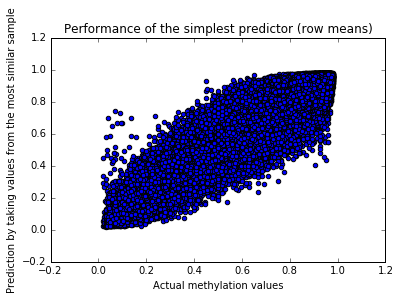

In [24]:
#skip
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(full_values_test_mod, samp_partial_test_mod)

plt.xlabel('Actual methylation values')
plt.ylabel('Prediction by taking values from the most similar sample')
plt.title('Performance of the simplest predictor (row means)')

plt.show()

In [55]:
#Take the weighted avg of top colQuant columns

sample_p_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_sample_partial.bed', sep='\t', header=None)
sample_f_bed = pandas.read_csv('data/intersected_final_chr1_cutoff_20_sample_full.bed', sep='\t', header=None)
impTable_m = impTable.as_matrix()

#Sort all the correlation values of the columns to the test set
corTestSorted = sorted(corTest, reverse = True)

#number of columns you want to use in the weighted avg
colQuant = 3
corSum = 0

for i in range(colQuant):
    corSum += corTestSorted[i][0]



samp_partial_test_mod = sample_p_bed[4].as_matrix()
full_values_test = sample_f_bed[4].as_matrix()

#sub in all nan's with weighted average with top cor colums values 
for x in range(len(samp_partial_test_mod)):
    if np.isnan(samp_partial_test_mod[x]):
        weight = 0
        for i in range(colQuant): 
            weight += impTable_m[x][corTestSorted[i][1]]*corTestSorted[i][0]
        samp_partial_test_mod[x] = weight/corSum 
        
full_values_test_mod = [full_values_test[x] for x in range(len(samp_partial_test_mod)) if ~np.isnan(full_values_test[x])]
samp_partial_test_mod = [samp_partial_test_mod[x] for x in range(len(samp_partial_test_mod)) if ~np.isnan(full_values_test[x])]
#print(full_values_test)
#print(samp_partial_test_mod)

print(np.corrcoef(samp_partial_test_mod, full_values_test_mod))
print(rmse(np.array(samp_partial_test_mod), np.array(full_values_test_mod)))

[[ 1.          0.92740938]
 [ 0.92740938  1.        ]]
0.0640299793692


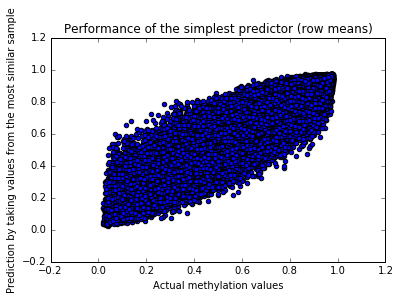

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(full_values_test_mod, samp_partial_test_mod)

plt.xlabel('Actual methylation values')
plt.ylabel('Prediction by taking values from the most similar sample')
plt.title('Performance of the simplest predictor (row means)')

plt.show()